In [1]:
from tqdm import tqdm
import cmocean as cmo
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import xarray as xr
import matplotlib.backends.backend_pdf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the options for BASIN
basin_options = {
    'Arabian Sea (AS)': 'AS',
    'Bay of Bengal (BoB)': 'BoB',
    'Both AS & BoB': 'BOTH'
}

# Define the options for TRACK_DATA
track_data_options = {
    'International Best Track Archive for Climate Stewardship (IBTrACS)': 'IBTrACS',
    'India Meteorological Department (IMD)': 'IMD',
    'Joint Typhoon Warning Center (JTWC)': 'JTWC',
}

# Define the options for DURATION
duration_options = {
    '5 days': 5,
    '3 days': 3
}

# Create the dropdown widgets
basin_widget = widgets.Dropdown(
    options=basin_options.keys(),
    description='BASIN:'
)

track_data_widget = widgets.Dropdown(
    options=track_data_options.keys(),
    description='BT DATASET:'
)

duration_widget = widgets.Dropdown(
    options=duration_options.keys(),
    description='AWR DURATION:'
)

# Initialize variables to store the selections
BASIN = None
TRACK_DATA = None
DURATION = None

# Function to update variables based on selections
def update_variables(basin, track_data, duration):
    global BASIN, TRACK_DATA, DURATION
    BASIN = basin_options[basin]
    TRACK_DATA = track_data_options[track_data]
    DURATION = duration_options[duration]
    
    print(f"ORIGIN BASIN selected\t\t: {BASIN}")
    print(f"BEST TRACK DATASET selected\t: {TRACK_DATA}")
    print(f"DURATION OF AWR selected\t: {DURATION} days")

# Display the dropdowns and set up interaction
interactive_widget = widgets.interactive(update_variables, basin=basin_widget, 
                                         track_data=track_data_widget, 
                                        duration = duration_widget)
display(interactive_widget)


interactive(children=(Dropdown(description='BASIN:', options=('Arabian Sea (AS)', 'Bay of Bengal (BoB)', 'Both…

In [3]:
# Reading in the processed data based on the options selected above and setting DATETIME as index.
# NOTE: If you want to look at a different basin/dataset, change the option above and re-run the
# code from this cell to the end of this notebook SEQUENTIALLY (as some variable names are being
# reused in some instances for making different plots).
bt_data = pd.read_csv('./processed/{}_TCBT_AS_BOB_1982-2023.csv'.format(TRACK_DATA))
bt_data['DATETIME'] = pd.to_datetime(bt_data['DATETIME'])
bt_data.set_index('DATETIME', inplace = True)

# Selecting data based on the ORIGIN_BASIN selection.
if BASIN != 'BOTH':
    bt_data = bt_data[bt_data['ORIGIN_BASIN'] == BASIN.upper()]

figures = []

### Centering TC data about its Lifetime Maximum Intensity point <br> (while cropping out any D or DD that don't develop into a CS)

In [4]:
tcs_lmi_centred = [] # Empty list to hold all the dataframes of individual TCs, after centering them about their LMI point.
count = 0 # To count the number of cyclone systems that don't mature into a cyclonic storm

# Loops through different TCs, uniquely grouped based on the cyClone ID (CS_ID)
for tc_id, tc_data in bt_data.groupby(bt_data['CS_ID']): 
    # The below if-statement is to check if any D or DD develops into a CS during it's lifetime.
    if any('CS' in item for item in set(bt_data[bt_data['CS_ID'] == tc_id]['CAT'].values)) == True:
        lmi_index = tc_data['MSWS'].idxmax() # To find the index of 
        # Finding the difference in time between when LMI was reached and all other timesteps of data points before/after LMI.
        tc_data['TimeRelativeToLMI'] = (tc_data.index - lmi_index).total_seconds() / (3600 * 24) # Converting it to days.
        tcs_lmi_centred += [tc_data]
    else:
        count += 1

print('{} systems out of {} didn\'t mature into a CS'.format(count, len(list(bt_data['CS_ID'].unique()))))
tcs_lmi_centred = pd.concat(tcs_lmi_centred) # Concatenating into a single dataframe of TCs centered about their respective LMI.

186 systems out of 326 didn't mature into a CS


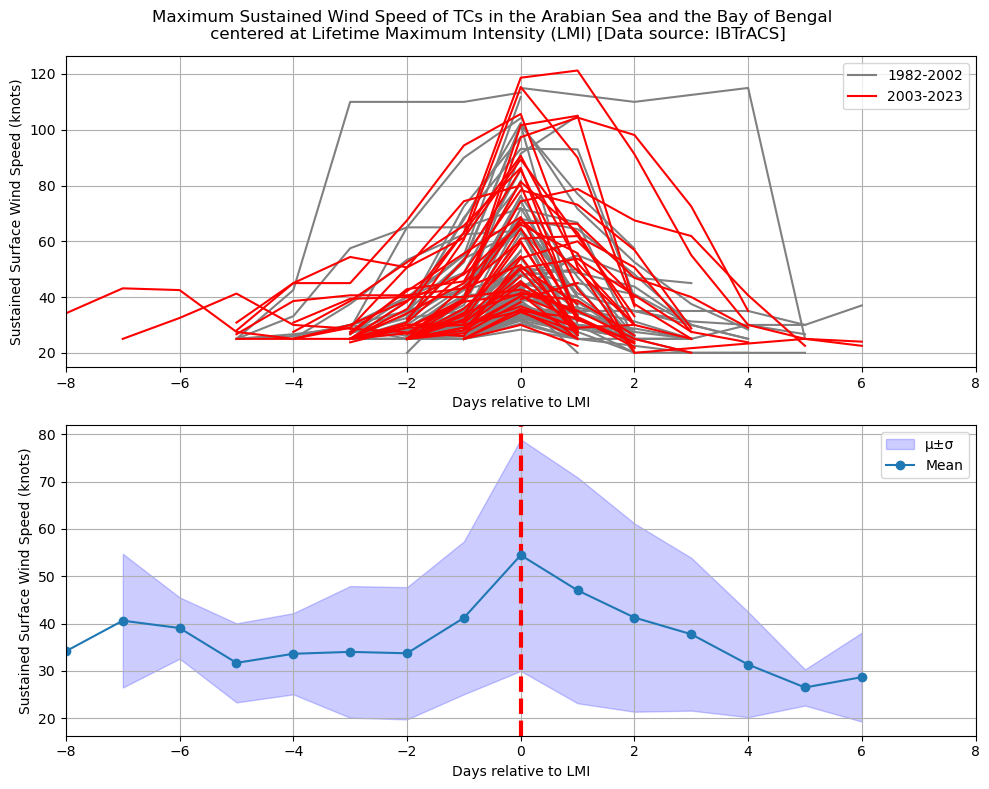

In [5]:
# Plotting Maximum Sustained Wind Speed of TCs as line plot and an ensemble mean+spread.

fig, axes = plt.subplots(2,1, figsize = (10,8))

if BASIN == 'BOTH':
    fig.suptitle('Maximum Sustained Wind Speed of TCs in the Arabian Sea and the Bay of Bengal \n centered at Lifetime Maximum Intensity (LMI) [Data source: {}]'.format(TRACK_DATA))
elif BASIN == 'AS':
    fig.suptitle('Maximum Sustained Wind Speed of TCs in the Arabian Sea \n centered at Lifetime Maximum Intensity (LMI) [Data source: {}]'.format(TRACK_DATA))
elif BASIN == 'BoB':
    fig.suptitle('Maximum Sustained Wind Speed of TCs in the Bay of Bengal \n centered at Lifetime Maximum Intensity (LMI) [Data source: {}]'.format(TRACK_DATA))

axes = axes.flatten()
for tc_id, tc_data in tcs_lmi_centred.groupby('CS_ID'):
    tc_data = tc_data[['MSWS', 'TimeRelativeToLMI']]
    tc_data.set_index('TimeRelativeToLMI', inplace = True)
    tc_data = tc_data.groupby(tc_data.index.astype(int)).mean() # Calculating daily mean values.
    if (int(str(tc_id)[0:4]) >= 1982) & (int(str(tc_id)[0:4]) <= 2012): # Grouping the TCs into two 'regimes', like recent past and historical.
        axes[0].plot(tc_data.index, tc_data['MSWS'], label = '1982-2002', color = 'gray')
    else:
        axes[0].plot(tc_data.index, tc_data['MSWS'], label = '2003-2023', color = 'red')

handles, labels = axes[0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
axes[0].legend(unique_labels.values(), unique_labels.keys())

axes[0].set_xlim([-8,8])
axes[0].set_xlabel('Days relative to LMI')
axes[0].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[0].grid(True)
####################
mean = tcs_lmi_centred.drop(['CAT', 'ORIGIN_BASIN', 'CS_ID'], axis = 1).groupby('TimeRelativeToLMI').mean()['MSWS']
std = tcs_lmi_centred.drop(['CAT', 'ORIGIN_BASIN', 'CS_ID'], axis = 1).groupby('TimeRelativeToLMI').std()['MSWS']

mean = mean.groupby(mean.index.astype(int)).mean() # Calculating daily mean values.
std = std.groupby(std.index.astype(int)).mean() # Calculating daily mean values

axes[1].axvline(0, color = 'red', ls = '--', lw = 3)
axes[1].fill_between(std.index, (mean-std), (mean+std), alpha = 0.2, color = 'blue', label = 'µ±σ')
axes[1].plot(mean.index, mean, marker = 'o', label = 'Mean')
axes[1].legend()
axes[1].set_xlim([-8,8])
axes[1].set_xlabel('Days relative to LMI')
axes[1].set_ylabel('Sustained Surface Wind Speed (knots)')
axes[1].grid(True)
fig.tight_layout()
figures += [fig]

# Classifying TCs based on MHW influence

### Definition used for classification: <br>

Definitions of MHW and NW intensified TCs have been inspired by <b>Choi et al., 2024</b>.

<u><b>MHW INTENSIFIED TC</b></u>: Tropical cyclones whose centres stayed within 'n'˚ of an MHW area for ≥ 'd' days immediately before reaching the LMI. 'n' and 'd' used in Choi et al., 2024 were 1˚ and 2 days.<br>

<u><b>NORMAL WARMING (NW) INTENSIFIED TC</b></u>: Tropical cyclones whose centres stayed within 'n'˚ of an area of 'normal warming' for ≥ 'd' days immediately before reaching the LMI. <br>

An area of 'normal warming' has been defined as temperatures within 60pctl and 90pctl, sustained over atleast 3 or 5 consecutive days (based on the abnormal warming duration selected initially). Whereas, an MHW area has been defined similarly but with temperatures over the 90pctl threshold i.e. extreme temperature cases.<br>

<u><b>NON-INFLUENCED TC</b></u>: Tropical cyclones which has NEVER encountered MHW or NW areas, for atleast 'd' days immediately before reaching the LMI. These may include TCs that may have encountered an abnormally warm area (either MHW or NW) after reaching LMI or > 'd' days before reaching LMI. <br>


### Citation:
Choi, HY., Park, MS., Kim, HS. et al. Marine heatwave events strengthen the intensity of tropical cyclones. Commun Earth Environ 5, 69 (2024). https://doi.org/10.1038/
s43247-024-01239-4

In [6]:
#### VARIABLES FOR CLASSIFICATION CRITERION ####

proximity_thres_to_awr = 1 
# How close-by the TC has to go to an abnormally warm area to be classed as one that's potentially influenced by that MHW?

d = 1 # How many days worth of data (atleast) before reaching LMI point is required? 
#'d' is also used to check if the TC BT stays within proximity_thres_to_awr degrees of an MHW area for these many days, before classifying it into a MHW TC or not.

In [7]:
# Loading in the AWR masks, based on the WARMING_TYPE and DURATION selected (Courtesy: https://github.com/ligin1/Marine-Heat-Waves by Ligin Joseph from Uni of Soton and NOCS UK)
mhw_mask, nw_mask = {},{}
for x in ['BOB', 'AS']:
    mhw_mask[x] = xr.open_dataset('./mhw_data/mhw_1982_2023_{}_{}days.nc'.format(x, DURATION)).rename({'__xarray_dataarray_variable__':'sst_mask'})
    nw_mask[x] = xr.open_dataset('./mhw_data/nw_1982_2023_{}_{}days.nc'.format(x, DURATION)).rename({'__xarray_dataarray_variable__':'sst_mask'})
    
    mhw_mask[x]['time'] = pd.to_datetime([str(x).split('T')[0] for x in mhw_mask[x].time.values])
    nw_mask[x]['time'] = pd.to_datetime([str(x).split('T')[0] for x in nw_mask[x].time.values])

### Selecting only the cyclones which had atleast 'd' days worth of data before reaching LMI point

In [8]:
df = pd.DataFrame(columns = ['TC_ID', 'FLAG'])
for tc_id, tc_data in tcs_lmi_centred.groupby(tcs_lmi_centred['CS_ID']):
    # Selecting only tc_data before LMI.
    if np.sum(tc_data[tc_data.TimeRelativeToLMI <= 0]['TimeRelativeToLMI']<=-d) != 0: 
        # Difference between when first and last entry (LMI) is recorded should be >= 24*d hrs
        tdelta = 1 # Flagging if the TC has 'd' days worth of data before reaching LMI or not.
    else:
        tdelta = 0
    df.loc[len(df)] = [tc_id, tdelta]

# Selecting LMI-centred TC data based on FLAG values determined through the above loop.
tcs_lmi_centred_selected = tcs_lmi_centred[tcs_lmi_centred['CS_ID'].isin(df[df['FLAG'] == 1]['TC_ID'].values)]

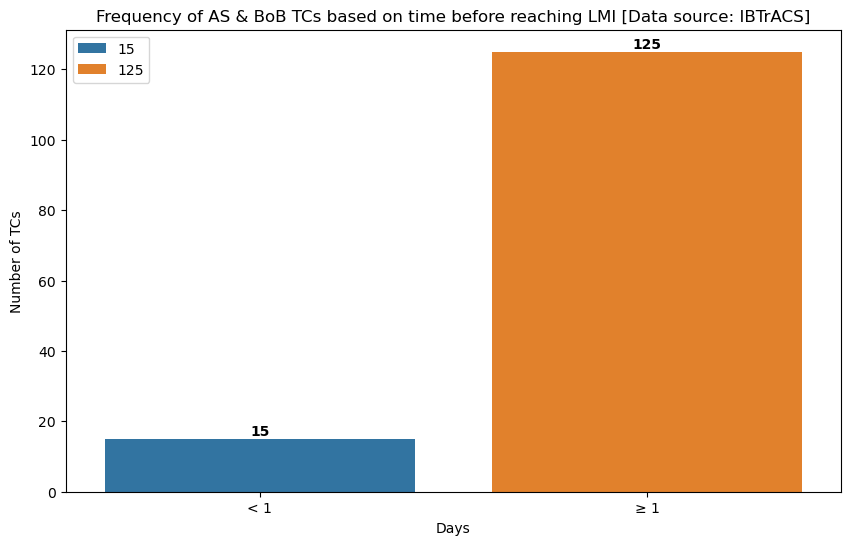

In [9]:
# Plot to illustrate the frequency of TCs based on how much time they take before reaching LMI
# Basically, it gives an idea of how many TCs satisfy the 'd' days condition described in the above cells.

counts = df['FLAG'].value_counts().sort_index()

# Map the values to '< d' and '≥ d'
labels = {0: '< {}'.format(d), 1: '≥ {}'.format(d)}
counts.index = counts.index.map(labels)

fig, ax = plt.subplots(1,1,figsize = (10,6))
sns.barplot(x=counts.index, y=counts.values, palette='tab10', hue = counts.values)

# Annotate the bars with the count
for i, value in enumerate(counts.values):
    ax.text(i, value + 0.1, f'{value}', ha='center', va='bottom', fontweight='bold')

if BASIN != 'BOTH':
    ax.set_title('Frequency of {} TCs based on time before reaching LMI [Data source: {}]'.format(BASIN, TRACK_DATA))
else:
    ax.set_title('Frequency of AS & BoB TCs based on time before reaching LMI [Data source: {}]'.format(TRACK_DATA))

ax.set_xlabel('Days')
ax.set_ylabel('Number of TCs')
figures += [fig]

### Checking the percentage of points that pass over an MHW or NW region (using 'nearest' gricell method to determine)

In [10]:
# Function to get the MHW mask value at the point closest to where a particular TC's best track passes through.
def get_sst_mask_val(mask, data_entry_row, origin_basin):
    return mask[origin_basin].sel(lat = data_entry_row[1]['LAT'], lon = data_entry_row[1]['LON'], time = data_entry_row[0], method = 'nearest')['sst_mask'].item()

In [11]:
df = pd.DataFrame(columns = ['TC_ID', 'PERCENT_POINTS_OVER_MHW', 'PERCENT_POINTS_OVER_NW'])
# Again, looping through different tropical cyclones.
for tc_id, tc_data in tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['CS_ID']):
    mhw_mask_vals, nw_mask_vals = [], []
    for x in tc_data.iterrows(): # Looping though each cyclones' data entries (i.e. rows).
        mhw_mask_vals = mhw_mask_vals + [get_sst_mask_val(mask = mhw_mask,data_entry_row = x, origin_basin = x[1]['ORIGIN_BASIN'])]
        nw_mask_vals = nw_mask_vals + [get_sst_mask_val(mask = nw_mask,data_entry_row = x, origin_basin = x[1]['ORIGIN_BASIN'])]
    
    mhw_mask_vals, nw_mask_vals  = np.array(mhw_mask_vals), np.array(nw_mask_vals)
    mhw_mask_vals[np.isnan(mhw_mask_vals)] = 0 # This takes care of any NaN values found in MHW mask over LAND.
    nw_mask_vals[np.isnan(nw_mask_vals)] = 0
    df.loc[len(df)] = [tc_id, np.round((mhw_mask_vals.sum()*100)/mhw_mask_vals.shape[0],2), np.round((nw_mask_vals.sum()*100)/nw_mask_vals.shape[0],2)]

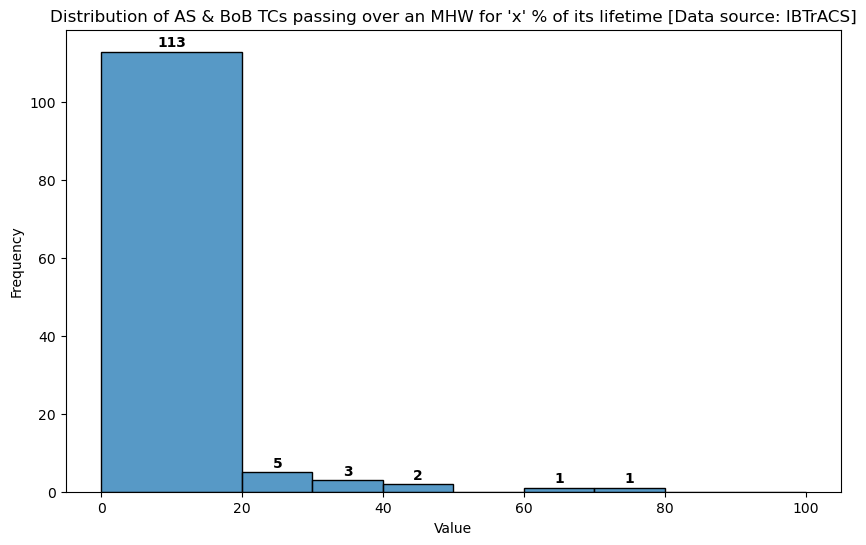

In [12]:
# Plot to show the distribution of TCs passing DIRECTLY over the MHW for 'x'% of its lifetime.
# e.g., if the 0-20% bar in the plot below show value as 40, it means that 40 TCs pass over 
# a MHW region about 0-20% of the time.
fig, ax = plt.subplots(1,1, figsize = (10,6))
histplot = sns.histplot(df['PERCENT_POINTS_OVER_MHW'], bins = [0,20,30,40,50,60,70,80,90,100], kde=False)  # Adjust bins as needed

# Annotate bars with the count
for patch in histplot.patches:
    # Get the height of each bar (which corresponds to the count)
    height = patch.get_height()
    # Only annotate if the height is greater than 0
    if height > 0:
        # Get the x-position of the center of the bar
        ax.text(patch.get_x() + patch.get_width() / 2, height + 0.5,  # Adjust the position if needed
                 f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')


ax.set_xticks(np.arange(0, 101, 20))
if BASIN != 'BOTH':
    ax.set_title("Distribution of {} TCs passing over an MHW for 'x' % of its lifetime [Data source: {}]".format(BASIN, TRACK_DATA))
else:
    ax.set_title("Distribution of AS & BoB TCs passing over an MHW for 'x' % of its lifetime [Data source: {}]".format(TRACK_DATA))
    
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
figures += [fig]

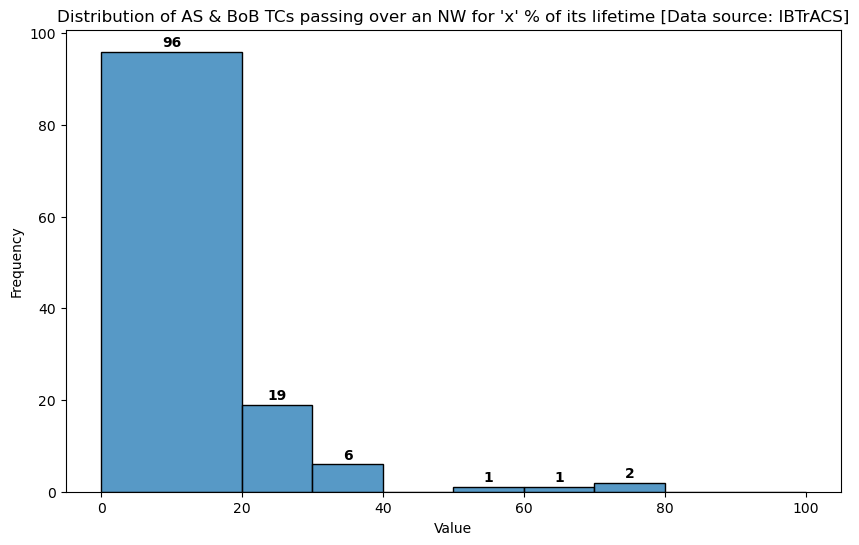

In [13]:
# Plot to show the distribution of TCs passing DIRECTLY over the NW for 'x'% of its lifetime.
# e.g., if the 0-20% bar in the plot below show value as 40, it means that 40 TCs pass over 
# a NW region about 0-20% of the time.
fig, ax = plt.subplots(1,1, figsize = (10,6))
histplot = sns.histplot(df['PERCENT_POINTS_OVER_NW'], bins = [0,20,30,40,50,60,70,80,90,100], kde=False)  # Adjust bins as needed

# Annotate bars with the count
for patch in histplot.patches:
    # Get the height of each bar (which corresponds to the count)
    height = patch.get_height()
    # Only annotate if the height is greater than 0
    if height > 0:
        # Get the x-position of the center of the bar
        ax.text(patch.get_x() + patch.get_width() / 2, height + 0.5,  # Adjust the position if needed
                 f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')


ax.set_xticks(np.arange(0, 101, 20))
if BASIN != 'BOTH':
    ax.set_title("Distribution of {} TCs passing over an NW for 'x' % of its lifetime [Data source: {}]".format(BASIN, TRACK_DATA))
else:
    ax.set_title("Distribution of AS & BoB TCs passing over an NW for 'x' % of its lifetime [Data source: {}]".format(TRACK_DATA))
    
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
figures += [fig]

In [14]:
# Function to calculate the distance in degrees between two points.
def distance_in_degrees(lat1, lon1, lat2, lon2):
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    # Adjust for the varying distance of longitude with latitude
    distance = np.sqrt(delta_lat**2 + (delta_lon * np.cos(np.radians(lat1)))**2)
    return distance

# Function to check if a TC track point is close to an AWR, based on the proximity threshold you set above.
def check_if_point_close_to_awr(awr_mask, x, thres = 1):
    origin_basin = x[1]['ORIGIN_BASIN']

    mask = awr_mask[origin_basin].sel(time = '{}-{:02d}-{}'.format(x[0].year, x[0].month, x[0].day))['sst_mask']

    # Given point (lat, lon)
    point_lon, point_lat = x[1]['LON'], x[1]['LAT']

    # Loop through all grid points and check if within {thres}-degree radius
    found_1_within_radius = False
    for lat_idx, lat in enumerate(mask['lat'].values):
        for lon_idx, lon in enumerate(mask['lon'].values):
            distance = distance_in_degrees(point_lat, point_lon, lat, lon)
            if distance <= thres:  # Check within {thres}-degree radius
                if mask[lat_idx, lon_idx] == 1:
                    found_1_within_radius = True
                    break
        if found_1_within_radius:
            break

    if found_1_within_radius:
        return 1
    else:
        return 0 

### Classifying and labelling TCs into NON-MHW, MHW and OTHER

In [15]:
df = pd.DataFrame(columns = ['CS_ID', 'CLASS'])
for tc_id, tc_data in tqdm(tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['CS_ID'])):
    # Assigning 'flags' (binary, 1 or 0) based on if the TC at any particular point is close to an AWR region.
    mhw_flag,nw_flag = [],[]
    for x in tc_data.iterrows():
        mhw_flag = mhw_flag + [check_if_point_close_to_awr(mhw_mask, x, thres = proximity_thres_to_awr)]
        nw_flag = nw_flag + [check_if_point_close_to_awr(nw_mask, x, thres = proximity_thres_to_awr)]
        
    tc_data['MHW_FLAG'] = mhw_flag
    tc_data['NW_FLAG'] = nw_flag


    # Selecting data for the last 5 days before reaching LMI.
    tc_data = tc_data[(tc_data.TimeRelativeToLMI <= 0) & (tc_data.TimeRelativeToLMI >= -5)]
    
    # Intensification flags based on proximity to an AWR region for consecutive 'd' days between day -5 and day 0.
    IS_MHW_INTENSIFIED, IS_NW_INTENSIFIED, IS_NOT_INTENSIFIED, IS_PARTLY_INTENSIFIED = False, False, False, False
    for idx in range(tc_data.shape[0]): # Loops through each row's index
        # Making sure the upper limit for subsetting data for 'd' days, doesn't cross 0.
        if ((tc_data['TimeRelativeToLMI'].iloc[idx]+d)<=0) == True:
            # Checking if all values for a subset of consecutive 'd' days between -5 to 0 is flagged to be close to an MHW region.
            if (tc_data[tc_data['TimeRelativeToLMI'] <= tc_data['TimeRelativeToLMI'].iloc[idx]+d]['MHW_FLAG'] == 1).all() == True:
                IS_MHW_INTENSIFIED = True
            # DONT CHANGE THIS TO if..elif: Irrespective of the above condition being True, the below NW check needs to be done.
            # Checking if all values for a subset of consecutive 'd' days between -5 to 0 is flagged to be close to an NW region.
            if (tc_data[tc_data['TimeRelativeToLMI'] <= tc_data['TimeRelativeToLMI'].iloc[idx]+d]['NW_FLAG'] == 1).all() == True:
                IS_NW_INTENSIFIED = True

    # If the TC doesn't interact with an MHW or NW between day -5 and 0, then it's classified as non-intensified TC.                
    if (tc_data['MHW_FLAG'].sum() == 0) & (tc_data['NW_FLAG'].sum() == 0):
        IS_NOT_INTENSIFIED = True
    
    if IS_MHW_INTENSIFIED == True:
        df.loc[len(df)] = [tc_id, 'MHW-INTENSIFIED']
    elif IS_NW_INTENSIFIED == True: # Interaction with an MHW takes precedence over interaction with an NW.
        # A TC may be close to an NW region AND an MHW region, then it'll be considered as an MHW-INTENSIFIED
        # TC. In some cases, NW regions tend to surround MHW regions, hence this consideration.
        df.loc[len(df)] = [tc_id, 'NW-INTENSIFIED']
    elif IS_NOT_INTENSIFIED == True:
        df.loc[len(df)] = [tc_id, 'NON-INTENSIFIED']
    else:
        df.loc[len(df)] = [tc_id, 'PARTLY-INTENSIFIED']

100%|█████████████████████████████████████████| 125/125 [08:37<00:00,  4.14s/it]


In [16]:
### OLD CLASSIFICATION METHODS: Checking only the immediate 'd' days before LMI.
################################################################################
# # Classifying based on proximity threshold to MHW, using the functions defined above.

# df = pd.DataFrame(columns = ['CS_ID', 'CLASS'])
# for tc_id, tc_data in tqdm(tcs_lmi_centred_selected.groupby(tcs_lmi_centred_selected['CS_ID'])):
#     mhw_flag,nw_flag = [],[]
#     for x in tc_data.iterrows():
#         mhw_flag = mhw_flag + [check_if_point_close_to_awr(mhw_mask, x, thres = proximity_thres_to_awr)]
#         nw_flag = nw_flag + [check_if_point_close_to_awr(nw_mask, x, thres = proximity_thres_to_awr)]
    
#     tc_data['MHW_FLAG'] = mhw_flag
#     tc_data['NW_FLAG'] = nw_flag
#     flags_d_days_before_lmi = tc_data[(tc_data.TimeRelativeToLMI <= 0) & (tc_data.TimeRelativeToLMI >= -d)]
#     if (flags_d_days_before_lmi['MHW_FLAG'].sum() == len(flags_d_days_before_lmi['MHW_FLAG'])):
#         # Condition for MHW-INTENSIFIED TC: At least all of the last 'd' days' entries before reaching the LMI point
#         # are close to any MHW-identified AWR gridcells. If all of the last 'd' days' entries are close to BOTH any MHW gricells 
#         # and any NW gridcells, then it's classified as an MHW intensified TC.
#         df.loc[len(df)] = [tc_id, 'MHW-INTENSIFIED']
#     elif (flags_d_days_before_lmi['NW_FLAG'].sum() == len(flags_d_days_before_lmi['NW_FLAG'])) & (flags_d_days_before_lmi['MHW_FLAG'].sum() != len(flags_d_days_before_lmi['MHW_FLAG'])):
#         # Condition for NW-INTENSIFIED TC: At least all of the last 'd' days' entries before reaching the LMI point
#         # are close to any NW-identified AWR gridcells. However, it CANNOT be close to an MHW gridcell for the ENTIRETY of the last 'd' days' entries.
#         df.loc[len(df)] = [tc_id, 'NW-INTENSIFIED']
#     elif (flags_d_days_before_lmi['MHW_FLAG'].sum() == 0) & (flags_d_days_before_lmi['NW_FLAG'].sum() == 0):
#         # Condition for NON-INTENSIFIED TC: At least all of the last 'd' days' entries before reaching the LMI point are NOT close to any AWR gridcells. 
#         df.loc[len(df)] = [tc_id, 'NON-INTENSIFIED']
#     elif (flags_d_days_before_lmi['MHW_FLAG'].sum() < len(flags_d_days_before_lmi['MHW_FLAG'])) & (flags_d_days_before_lmi['NW_FLAG'].sum() < len(flags_d_days_before_lmi['NW_FLAG'])):
#         # Condition for NON-INTENSIFIED TC: At least some of the last 'd' days' entries before reaching the LMI point are close to either an MHW or an NW AWR gridcells.
#         df.loc[len(df)] = [tc_id, 'PARTLY-INTENSIFIED']
#     else:
#         # To see if any of the TCs are left out UNCLASSED
#         df.loc[len(df)] = [tc_id, 'UNCLASSED']

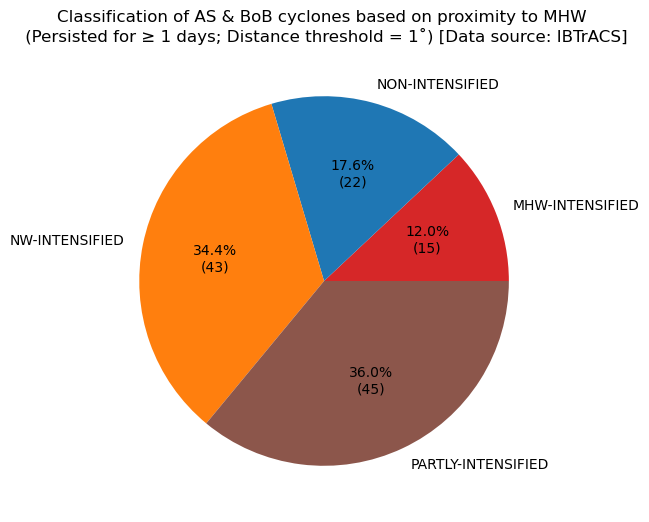

In [17]:
# Pie-chart distribution of MHW, NON-MHW and OTHER (i.e. partly influenced) TCs.
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

fig, ax = plt.subplots(1,1, figsize = (10,6))

s = df['CLASS'].value_counts().sort_index()
if BASIN != 'BOTH':
     ax.set_title('Classification of {} cyclones based on proximity to MHW \n Persisted for ≥ {} days; Distance threshold = {}˚ [Data source: {}]'.format(BASIN, d, proximity_thres_to_awr, TRACK_DATA))
else:
     ax.set_title('Classification of AS & BoB cyclones based on proximity to MHW \n (Persisted for ≥ {} days; Distance threshold = {}˚) [Data source: {}]'.format(d, proximity_thres_to_awr, TRACK_DATA))
ax.pie(s,labels = s.index, autopct=autopct_format(s), colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:brown'])
figures += [fig]

In [18]:
# Assigning CLASS of AWR-influence for each entry of the tcs_lmi_centred_selected dataset, indexed based on the cyclone ID (CS_ID).

tcs_lmi_centred_selected.loc[:,'TC_AWRINT_CLASS'] = ""
for _, row in df.iterrows():
    tcs_lmi_centred_selected.loc[tcs_lmi_centred_selected['CS_ID'] == row['CS_ID'],'TC_AWRINT_CLASS'] = row['CLASS']

/tmp/ipykernel_24684/208582771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcs_lmi_centred_selected.loc[:,'TC_AWRINT_CLASS'] = ""


In [19]:
# Saving the classified output as a .csv file
if BASIN != 'BOTH':
    tcs_lmi_centred_selected.to_csv('./output/{}_{}_pt{:03d}_d{:02d}_awrdur{}_CS_ID_CLASSIFIED.csv'.format(TRACK_DATA, BASIN, int(100*proximity_thres_to_awr), d, DURATION))
else:
    tcs_lmi_centred_selected.to_csv('./output/{}_{}_pt{:03d}_d{:02d}_awrdur{}_CS_ID_CLASSIFIED.csv'.format(TRACK_DATA, 'AS_AND_BOB', int(100*proximity_thres_to_awr), d, DURATION))

---

## Plotting TC MSWS as an ensemble after grouping by AWR-influence class

In [20]:
# Plotting function to plot grouped ensembles based on AWR-influence class
def ensemble_plotter(tcs_lmi_centred = None, ax = None, c = None, tc_type = None, time_rels = None, rolling = False, window = 3):
    interpolated_dfs = []
    for tc_id, tc_data in tcs_lmi_centred.groupby(tcs_lmi_centred['CS_ID']):
        interpolated_dfs += [interpolate_dataframe(tc_data.reset_index()[['TimeRelativeToLMI', 'MSWS']], set_TimeRelativeToLMI = time_rels)]
    
    mean = pd.concat(interpolated_dfs).groupby('TimeRelativeToLMI').mean()['MSWS']
    std = pd.concat(interpolated_dfs).groupby('TimeRelativeToLMI').std()['MSWS']

    if rolling == True:
        mean = mean.rolling(window = 3, center = True).mean()
        std = std.rolling(window = 3, center = True).mean()

    #ax.fill_between(std.index, (mean-1*std), (mean+1*std), alpha = 0.05, color = c, label = tc_type+': µ±σ')
    ax.plot(mean.index, mean, marker = 'o', label = tc_type+': Mean', color = c)


# Function to interpolate TC dataframe to a set list of TimeRelativeToLMI values
def interpolate_dataframe(tc_data = None, set_TimeRelativeToLMI = np.arange(-5,5,0.125)):
    # Perform interpolation
    interpolated_msws = np.interp(set_TimeRelativeToLMI, tc_data['TimeRelativeToLMI'].values, tc_data['MSWS'].values, left = np.nan, right = np.nan)

    # Create new interpolated dataframe
    interpolated_df = pd.DataFrame({
        'TimeRelativeToLMI': set_TimeRelativeToLMI,
        'MSWS': interpolated_msws
    })

    return interpolated_df


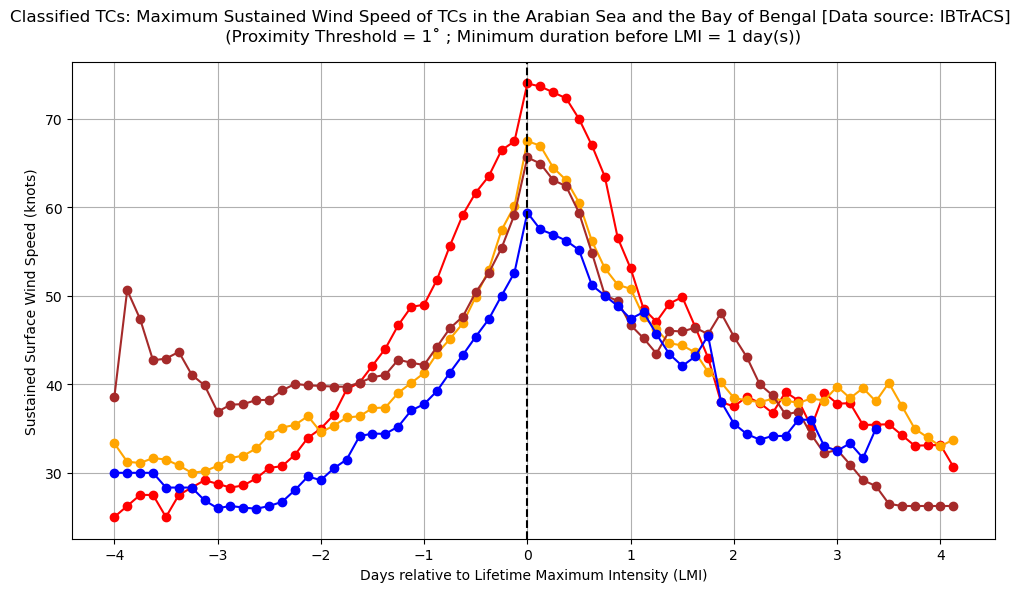

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
if BASIN == 'BOTH':
    fig.suptitle('Classified TCs: Maximum Sustained Wind Speed of TCs in the Arabian Sea and the Bay of Bengal [Data source: {}]\n (Proximity Threshold = {}˚ ; Minimum duration before LMI = {} day(s))'.format(TRACK_DATA, proximity_thres_to_awr, d))
elif BASIN == 'AS':
    fig.suptitle('Classified TCs: Maximum Sustained Wind Speed of TCs in the Arabian Sea [Data source: {}]\n (Proximity Threshold = {}˚ ; Minimum duration before LMI = {} day(s))'.format(TRACK_DATA, proximity_thres_to_awr, d))
elif BASIN == 'BoB':
    fig.suptitle('Classified TCs: Maximum Sustained Wind Speed of TCs in the Bay of Bengal [Data source: {}]\n (Proximity Threshold = {}˚ ; Minimum duration before LMI = {} day(s))'.format(TRACK_DATA, proximity_thres_to_awr, d))

time_rels = np.arange(-4,4.25,0.125)
ensemble_plotter(tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == 'MHW-INTENSIFIED'], ax, 'red', tc_type = 'MHW-INTENSIFIED', time_rels = time_rels, rolling = False, window = 3)
ensemble_plotter(tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == 'NW-INTENSIFIED'], ax, 'orange', tc_type = 'NW-INTENSIFIED', time_rels = time_rels, rolling = False, window = 3)
ensemble_plotter(tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == 'PARTLY-INTENSIFIED'], ax, 'brown', tc_type = 'PARTLY-INTENSIFIED', time_rels = time_rels, rolling = False, window = 3)
ensemble_plotter(tcs_lmi_centred_selected[(tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == 'NON-INTENSIFIED')], ax, 'blue', tc_type = 'NON-INTENSIFIED', time_rels = time_rels, rolling = False, window = 3)
ax.axvline(0, color = 'black', ls = '--', lw = 1.5)
#ax.legend(ncols = 2)
#ax.set_xlim([-5,5])
ax.set_xlabel('Days relative to Lifetime Maximum Intensity (LMI)')
ax.set_ylabel('Sustained Surface Wind Speed (knots)')
ax.grid(True)
fig.tight_layout()
figures += [fig]

In [22]:
# Dictionary to save frequency per category for each class of TCs
type_freq_per_cat = {}
for tc_type in ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']:
    # Subsetting dataframe based on TC class ('tc_type').
    cropped = tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_type]
    # Selecting category at LMI.
    cropped = cropped[cropped['TimeRelativeToLMI'] == 0][['CS_ID', 'CAT', 'ORIGIN_BASIN']]
    cropped.set_index('CS_ID', inplace = True)
    # Dictionary to save the number (or count) of TCs for each category, for each basin.
    number_per_category = {'BOB':{'CS':0, 'SCS':0, 'ESCS':0,'VSCS':0,'SUCS':0}, 'AS':{'CS':0, 'SCS':0, 'ESCS':0,'VSCS':0,'SUCS':0}}

    # Looping over cropped dataset after grouping by 'ORIGIN_BASIN'.
    for basin, basin_cropped_df in cropped.groupby('ORIGIN_BASIN'):
        # Looping over each category and respective number, using 'basin_cropped_df'.
        for cat,num in zip(basin_cropped_df['CAT'].value_counts().index, basin_cropped_df['CAT'].value_counts().values):
            number_per_category[basin][cat] = num

    # Combining both the basins' TC frequency per catgegory and adding it to the dictionary.
    number_per_category['BOTH'] = {key: number_per_category['AS'][key] + number_per_category['BOB'][key] for key in number_per_category['AS']}

    # Saving the frequency-category dictionary for each TC class.
    type_freq_per_cat[tc_type] = number_per_category

In [23]:
##### FUNCTION TO PLOT FREQUENCY PROPORTION OF EACH CYCLONE CATEGORY FOR EACH CLASS OF TCs ######
def freq_plotter(basin, ax = None):
    # Calculating percentage proportion for each frequency-category dictionary of each TC class.
    mhw_intensified_tc_proportion = {key: round(value * (100/sum(type_freq_per_cat['MHW-INTENSIFIED'][basin].values())),2) for key, value in type_freq_per_cat['MHW-INTENSIFIED'][basin].items()}
    nw_intensified_tc_proportion = {key: round(value * (100/sum(type_freq_per_cat['NW-INTENSIFIED'][basin].values())),2) for key, value in type_freq_per_cat['NW-INTENSIFIED'][basin].items()}
    partly_intesified_tc_proportion = {key: round(value * (100/sum(type_freq_per_cat['PARTLY-INTENSIFIED'][basin].values())),2) for key, value in type_freq_per_cat['PARTLY-INTENSIFIED'][basin].items()}
    non_intensified_tc_proportion = {key: round(value * (100/sum(type_freq_per_cat['NON-INTENSIFIED'][basin].values())),2) for key, value in type_freq_per_cat['NON-INTENSIFIED'][basin].items()}


    # Extracting keys and values.
    tc_categories = list(mhw_intensified_tc_proportion.keys())
    mhw_intensified_values = list(mhw_intensified_tc_proportion.values())
    nw_intensified_values = list(nw_intensified_tc_proportion.values())
    partly_intesified_values = list(partly_intesified_tc_proportion.values())
    non_intensified_values = list(non_intensified_tc_proportion.values())

    # Setting width for each bar.
    bar_width = 0.2
    # Setting the positions of the bars on the x-axis.
    r1 = np.arange(len(tc_categories))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Plotting the bars side-by-side.
    ax.bar(r1, mhw_intensified_values, color='tab:red', width=bar_width, edgecolor='black', label='MHW-INTENSIFIED')
    ax.bar(r2, nw_intensified_values, color='tab:orange', width=bar_width, edgecolor='black', label='NW-INTENSIFIED')
    ax.bar(r3, partly_intesified_values, color='tab:brown', width=bar_width, edgecolor='black', label='PARTLY-INTENSIFIED')
    ax.bar(r4, non_intensified_values, color='tab:blue', width=bar_width, edgecolor='black', label='NON-INTENSIFIED')

    ax.set_xlabel('TC Category')
    ax.set_ylabel('Proportion %')
    
    if basin == 'BOTH':
        fig.suptitle('Proportion of TC categories for different TC classes [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, 'AS & BoB'))    
    else:
        fig.suptitle('Proportion of TC categories for different TC classes [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, basin))

    # Annotate the top of each bar with the bar's value (i.e. percentage proportion).
    for i in range(len(r1)):
        ax.text(r1[i], mhw_intensified_values[i], str(mhw_intensified_values[i]), ha='center', va = 'top', weight = 'bold', fontsize = 10, color = 'white', rotation = 90)
        ax.text(r2[i], nw_intensified_values[i], str(nw_intensified_values[i]), ha='center', va = 'top', weight = 'bold', fontsize = 10, color = 'white', rotation = 90)
        ax.text(r3[i], partly_intesified_values[i], str(partly_intesified_values[i]), ha='center', va = 'top', weight = 'bold', fontsize = 10, color = 'white', rotation = 90)
        ax.text(r4[i], non_intensified_values[i], str(non_intensified_values[i]), ha='center', va = 'top', weight = 'bold', fontsize = 10, color = 'white', rotation = 90)

    ax.set_title(basin)
    ax.set_xticks([r + bar_width for r in range(len(tc_categories))], tc_categories)
    ax.legend()
    ax.grid(alpha = 0.3)

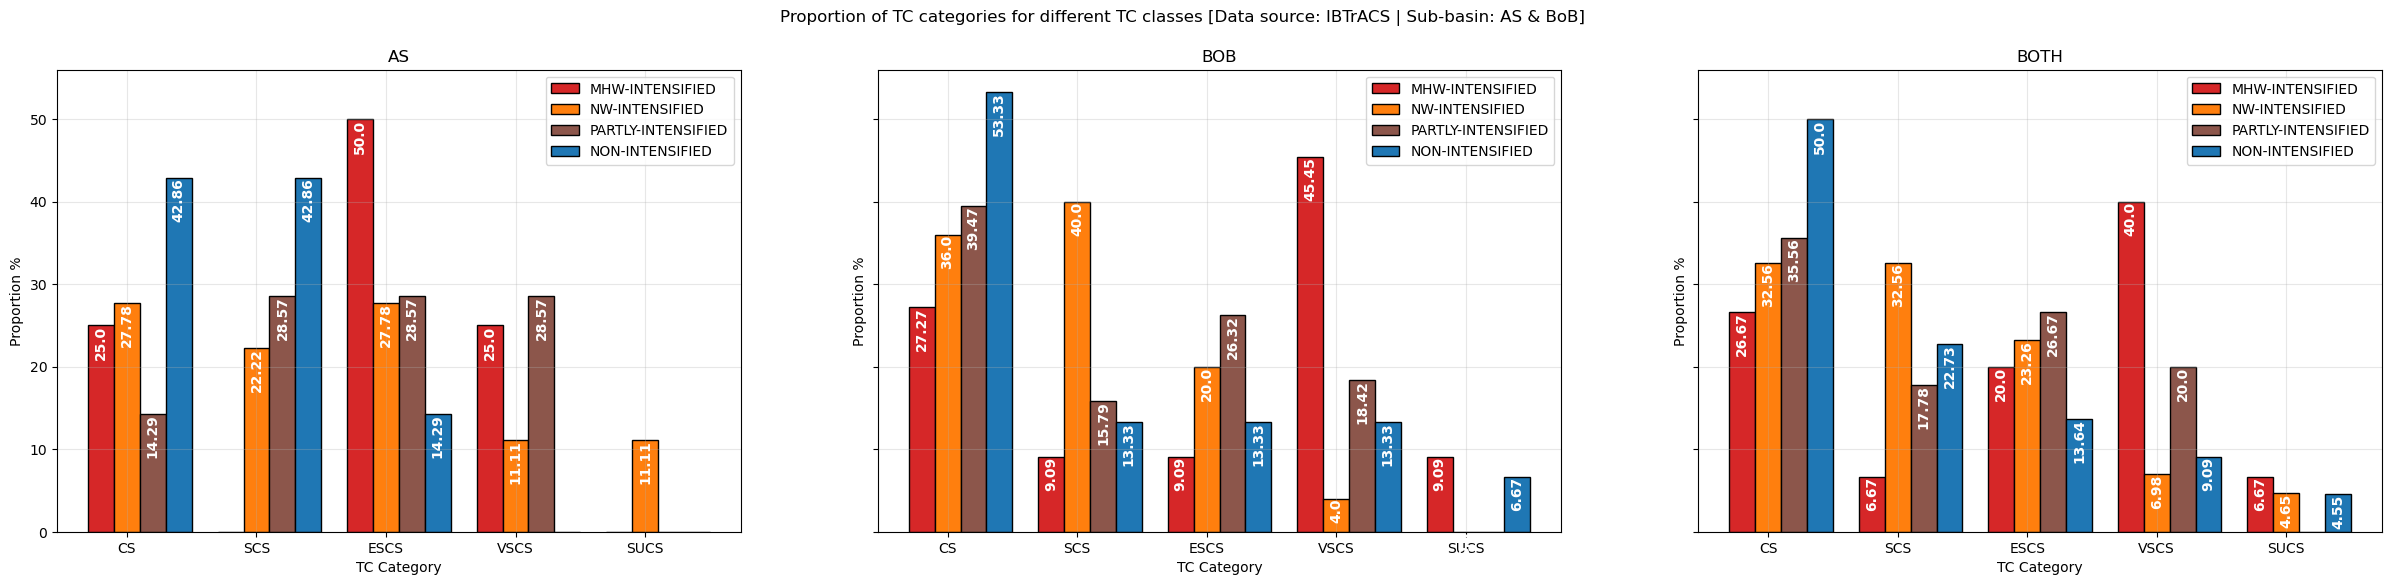

In [24]:
# Plotting proportion of TC categories for different TC classes

if BASIN == 'BOTH':
    fig, axes = plt.subplots(1,3, figsize = (30,6), sharex = True, sharey = True)
    axes = axes.flatten()
    freq_plotter('AS', ax = axes[0])
    freq_plotter('BOB', ax = axes[1])
    freq_plotter('BOTH', ax = axes[2])
else:
    fig, ax = plt.subplots(1,1, figsize = (10,6), sharex = True, sharey = True)
    freq_plotter(BASIN.upper(), ax = ax)

figures += [fig]

---

## Analysing auxillary variables from ERA5 3-hourly data

In [25]:
# Reading in the ERA5 datasets, which have been cropped to be over North Indian Ocean
era5_ds = {'1982-1991':xr.open_dataset('./era5_data/ERA5_10m_u_v_lhf_precip_3h_1982_1991.nc'),
           '1992-2001':xr.open_dataset('./era5_data/ERA5_10m_u_v_lhf_precip_3h_1992_2001.nc'),
           '2002-2011':xr.open_dataset('./era5_data/ERA5_10m_u_v_lhf_precip_3h_2002_2011.nc'),
           '2012-2021':xr.open_dataset('./era5_data/ERA5_10m_u_v_lhf_precip_3h_2012_2021.nc'),
           '2022-2024':xr.open_dataset('./era5_data/ERA5_10m_u_v_lhf_precip_3h_2022_2024_18_aug.nc')}

In [26]:
# Removing duplicate indices for the sake of making spatial composites.
tcs_lmi_centred_selected = tcs_lmi_centred_selected[~tcs_lmi_centred_selected.index.duplicated(keep='first')]

In [27]:
#### FUNCTION TO PAD DATASET ####

def dataset_padder(data):
    target_shape = (41, 41)  # A 10˚ x 10˚ subset of ERA5 data (0.25˚ horizontal resolution, regular lat/lon grid) is of shape (41, 41)
    
    # Calculate padding amounts for each dimension
    pad_x_after = (target_shape[0] - data['longitude'].shape[0]) // 2  # Padding to add after for x-dimension
    pad_x_before = (target_shape[0] - data['longitude'].shape[0]) - pad_x_after  # Padding to add before for x-dimension
    
    pad_y_after = (target_shape[1] - data['latitude'].shape[0]) // 2   # Padding to add after for y-dimension
    pad_y_before = (target_shape[1] - data['latitude'].shape[0]) - pad_y_after  # Padding to add before for y-dimension

    # Padding along longitude
    data = data.pad(longitude = (pad_x_before,pad_x_after), constant_value = np.nan)
    # Padding along latitude
    data = data.pad(latitude = (pad_y_before,pad_y_after), constant_value = np.nan)
    
    return data

In [28]:
# Dictionary to save frequency per category for each class of TCs
type_freq_per_cat = {}
for tc_type in ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']:
    # Subsetting dataframe based on TC class ('tc_type').
    cropped = tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_type]
    # Selecting category at LMI.
    cropped = cropped[cropped['TimeRelativeToLMI'] == 0][['CS_ID', 'CAT', 'ORIGIN_BASIN']]
    cropped.set_index('CS_ID', inplace = True)
    # Dictionary to save the number (or count) of TCs for each category, for each basin.
    number_per_category = {'BOB':{'CS':0, 'SCS':0, 'ESCS':0,'VSCS':0,'SUCS':0}, 'AS':{'CS':0, 'SCS':0, 'ESCS':0,'VSCS':0,'SUCS':0}}

    # Looping over cropped dataset after grouping by 'ORIGIN_BASIN'.
    for basin, basin_cropped_df in cropped.groupby('ORIGIN_BASIN'):
        # Looping over each category and respective number, using 'basin_cropped_df'.
        for cat,num in zip(basin_cropped_df['CAT'].value_counts().index, basin_cropped_df['CAT'].value_counts().values):
            number_per_category[basin][cat] = num

    # Combining both the basins' TC frequency per catgegory and adding it to the dictionary.
    number_per_category['BOTH'] = {key: number_per_category['AS'][key] + number_per_category['BOB'][key] for key in number_per_category['AS']}

    # Saving the frequency-category dictionary for each TC class.
    type_freq_per_cat[tc_type] = number_per_category

In [29]:
# Dictionary to save data subsetted for select timestamps/location 
# where BT of a particular class of TC passes over. This dataset will
# later be used to calculate composite means and its spatial average.
era5_ds_tcs = {}  

# Looping over each category of TC, as classified above.
for c in ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']:
    era5_ds_tcs[c] = [] # List to store dataset for each timestep.
    tcs_df_subset = tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == c]
    for row in tqdm(tcs_df_subset.iterrows()):
        # Here, 'row' is each data entry for cyclones classified as 'c' earlier.
        # Selecting data at a particular timestep ('row' index value) from the appropriate ERA5 dataset.
        if 1982 <= row[0].year <= 1991:
            ds_selected = era5_ds['1982-1991'].sel(valid_time = row[0], drop = False, method = 'nearest')
        elif 1992 <= row[0].year <= 2001:
            ds_selected = era5_ds['1992-2001'].sel(valid_time = row[0], drop = False, method = 'nearest')
        elif 2002 <= row[0].year <= 2011:
            ds_selected = era5_ds['2002-2011'].sel(valid_time = row[0], drop = False, method = 'nearest')
        elif 2012 <= row[0].year <= 2021:
            ds_selected = era5_ds['2012-2021'].sel(valid_time = row[0], drop = False, method = 'nearest')
        elif 2022 <= row[0].year <= 2024:
            ds_selected = era5_ds['2022-2024'].sel(valid_time = row[0], drop = False, method = 'nearest')

        # Sorting selected dataset based on ascending order of 'latitude' and 'longitude'.   
        ds_selected = ds_selected.sortby('latitude')
        ds_selected = ds_selected.sortby('longitude')

        # Finding out which lat/lon of the ERA5 grid is nearest to the lat/lon of 'row'.
        latn = ds_selected['latitude'].sel(latitude = row[1]['LAT'], method = 'nearest').item()
        lonn = ds_selected['longitude'].sel(longitude = row[1]['LON'], method = 'nearest').item()

        # Subsetting a 10˚ x 10˚ box, with centre as 'latn' and 'lonn' determined from the above step.
        ds_selected = ds_selected.sel(latitude = slice(latn-5.15, latn+5.15), longitude = slice(lonn-5.05, lonn+5.05))
        # As some BT locations (i.e., 'latn/lonn') fall close to the boundary points of 'ds_selected',
        # it may not be possible to crop exactly 10˚ x 10˚ box i.e., (41,41) shaped box.
        # Hence, to deal with this issue I've made this dataset_padder() function, which pads both ends
        # of the box (both in vertical and horizontal directions) with NaN values to preserve shape.
        # This is particularly needed when merging cropped datasets for each timestep into a single
        # dataset at the end of each iteration (below).
        ds_selected = dataset_padder(ds_selected)

        # Revaluing 'latitude' and 'longitude' to be ranging from -5˚ to 5˚ with (0˚,0˚) as the centre
        # over which the BT passes, at each timestep.
        ds_selected['latitude'] = np.arange(-5,5.1, 0.25)
        ds_selected['longitude'] = np.arange(-5,5.1, 0.25)
        # Drop unneccesary variables that have been pre-identified, if they exist in ds_selected.
        ds_selected = ds_selected.drop_vars('valid_time')
        if 'number' in list(ds_selected.coords):
            ds_selected = ds_selected.drop_vars('number')
        elif 'expver' in list(ds_selected.coords):
            ds_selected = ds_selected.drop_vars('expver')
        # As we've selected a single timestep, we lose that dimension from the dataset. Here I'm simply 
        # adding it back. This will be useful for merging the datasets immediately after this loop.
        ds_selected = ds_selected.expand_dims({'time':[row[0]]})

        # Adding the dataset for 'row' timestep to the list.
        era5_ds_tcs[c] += [ds_selected]
        
    # Merging the datasets based across the 'valid_time' axis.
    era5_ds_tcs[c] = xr.merge(era5_ds_tcs[c])

    # Assigning 'TimeRelativeToLMI' as a coordinate with 'time' as the dimension.
    # This will be used to group-by and take a mean, hence creating a composite for each 'TimeRelativeToLMI'.
    era5_ds_tcs[c]['TimeRelativeToLMI'] = list(tcs_df_subset['TimeRelativeToLMI'])
    era5_ds_tcs[c] = era5_ds_tcs[c].assign_coords(TimeRelativeToLMI = ('time', list(tcs_df_subset['TimeRelativeToLMI'])))

464it [00:14, 32.29it/s]
1330it [00:35, 37.98it/s]
1186it [00:35, 33.57it/s]
481it [00:14, 33.89it/s]


/tmp/ipykernel_24684/704732082.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


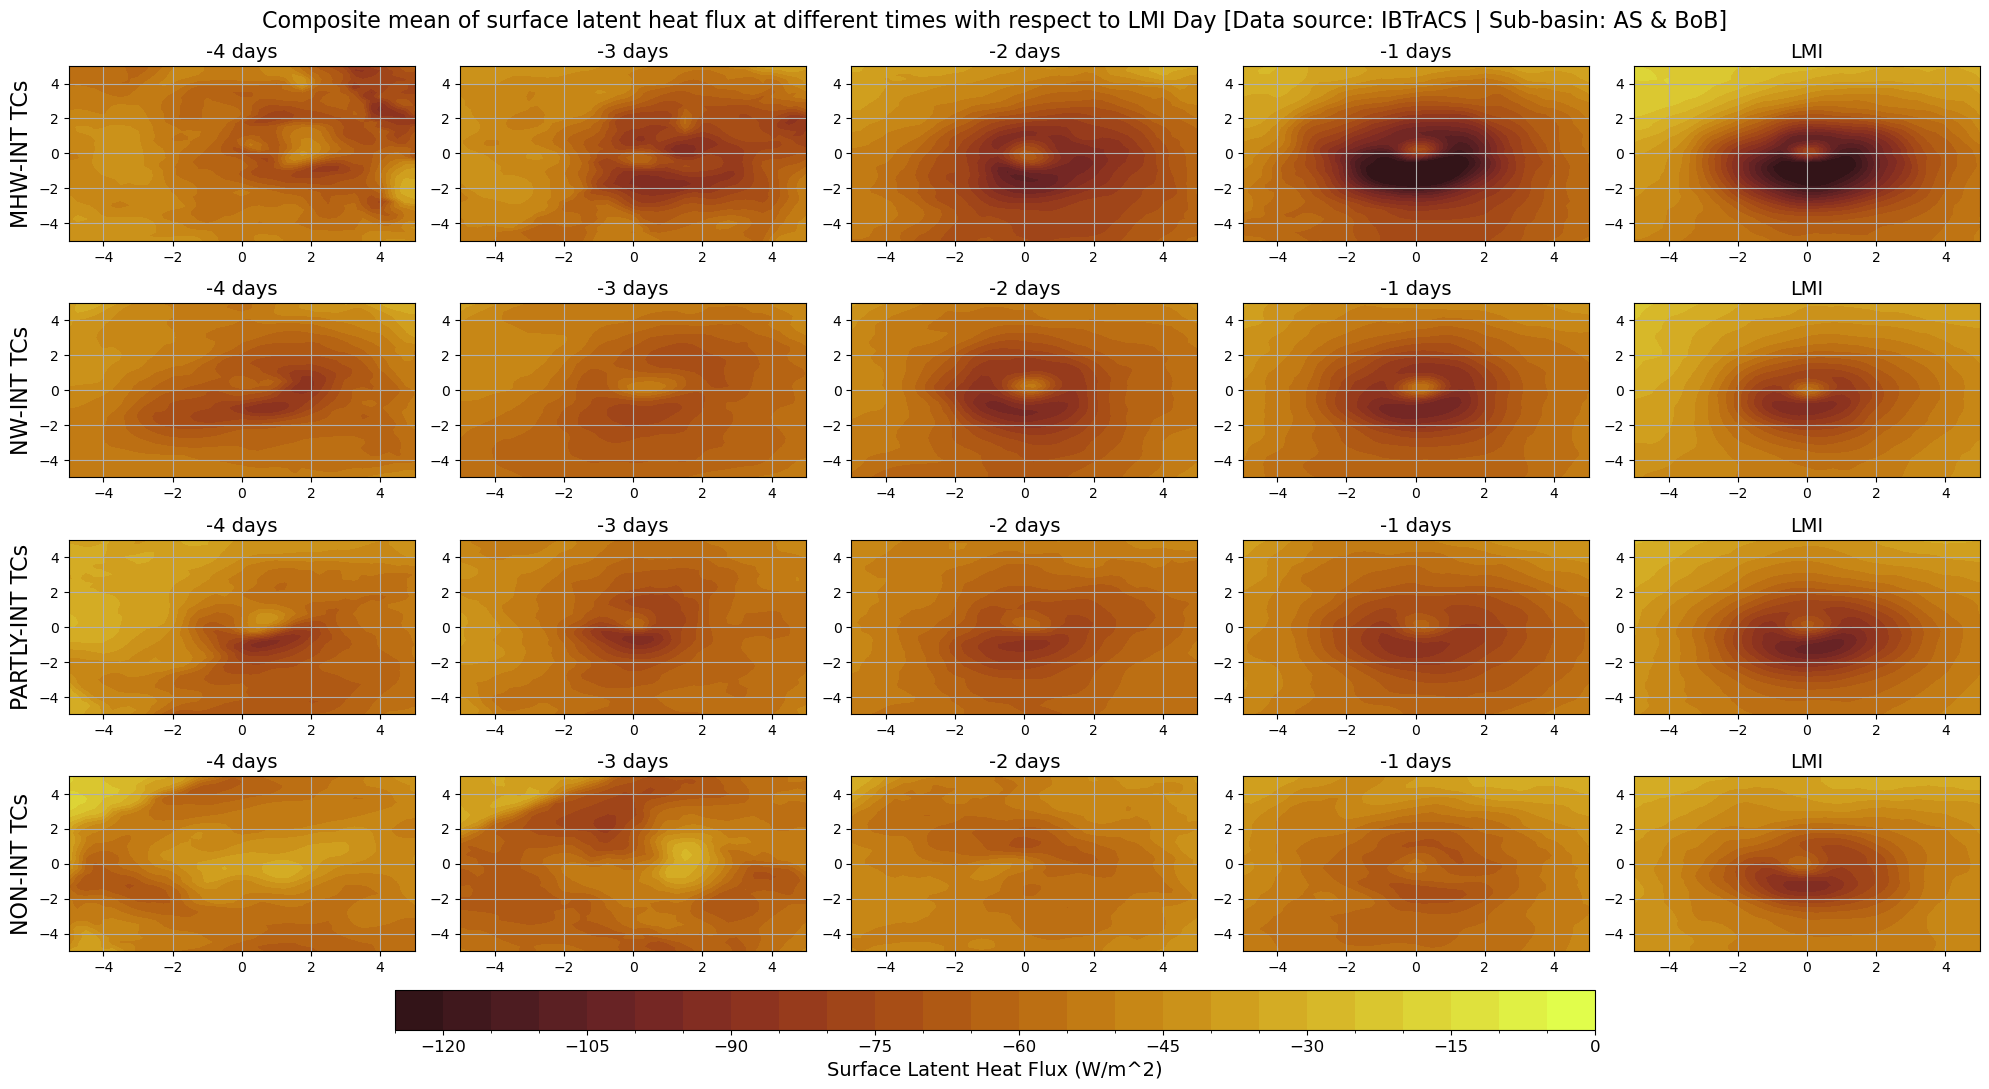

In [30]:
# Plotting composite mean surface latent heat flux in lead up to LMI day.

# Making a 4 x 5 grid, where each row is for composite of each TC class and each column is the 'TimeRelativeToLMI'
fig, axes = plt.subplots(4,5, figsize = (20,10)) 
if BASIN != 'BOTH':
    fig.suptitle('Composite mean of surface latent heat flux at different times with respect to LMI Day [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, BASIN), fontsize = 16)
else:
    fig.suptitle('Composite mean of surface latent heat flux at different times with respect to LMI Day [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, 'AS & BoB'), fontsize = 16)
axes = axes.flatten()

classes = ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']
for idx in range(20):
    c = classes[idx//5] # Picking out class based on which row the axis index belongs to.
    # Grouping data (based on integer value of 'TimeRelativeToLMI') and taking composite mean
    era5_ds_tcs_averaged = era5_ds_tcs[c].groupby(era5_ds_tcs[c].TimeRelativeToLMI.astype('int')).mean()
    # Converting 3-hourly J/m^2 data to W/m^2 units, by dividing Surface LHF with the number of seconds in 3 hours.
    # Plotting filled-countour plot after converting surface latent heat flux ('slhf') variable.
    cbar_map = (era5_ds_tcs_averaged['slhf']/(3*3600)).sel(TimeRelativeToLMI = -4+idx%5).plot.contourf(ax = axes[idx], 
                                                                                                       levels = np.arange(-125,0.1, 5), 
                                                                                                       cmap = cmo.cm.solar, 
                                                                                                       add_colorbar = False)
    axes[idx].set_xlabel('')

    # Labelling TC class at the start of the row.
    if idx%5 == 0.:
        axes[idx].set_ylabel(c.split('INT')[0]+'INT'+' TCs', fontsize = 16)
    else:
        axes[idx].set_ylabel('')

    # Labelling 'TimeRelativeToLMI' for each column.
    if (-4+idx%5) != 0:
        axes[idx].set_title(str(-4+idx%5) + ' days', fontsize = 14)
    else:
        axes[idx].set_title('LMI', fontsize = 14)
    axes[idx].grid(True)

# Adding common colorbar
cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04])
cbar=fig.colorbar(cbar_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label= "Surface Latent Heat Flux (W/m^2)", size = 14)
cbar.ax.tick_params(labelsize=12)
fig.tight_layout()
figures += [fig]

/tmp/ipykernel_24684/2700526954.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


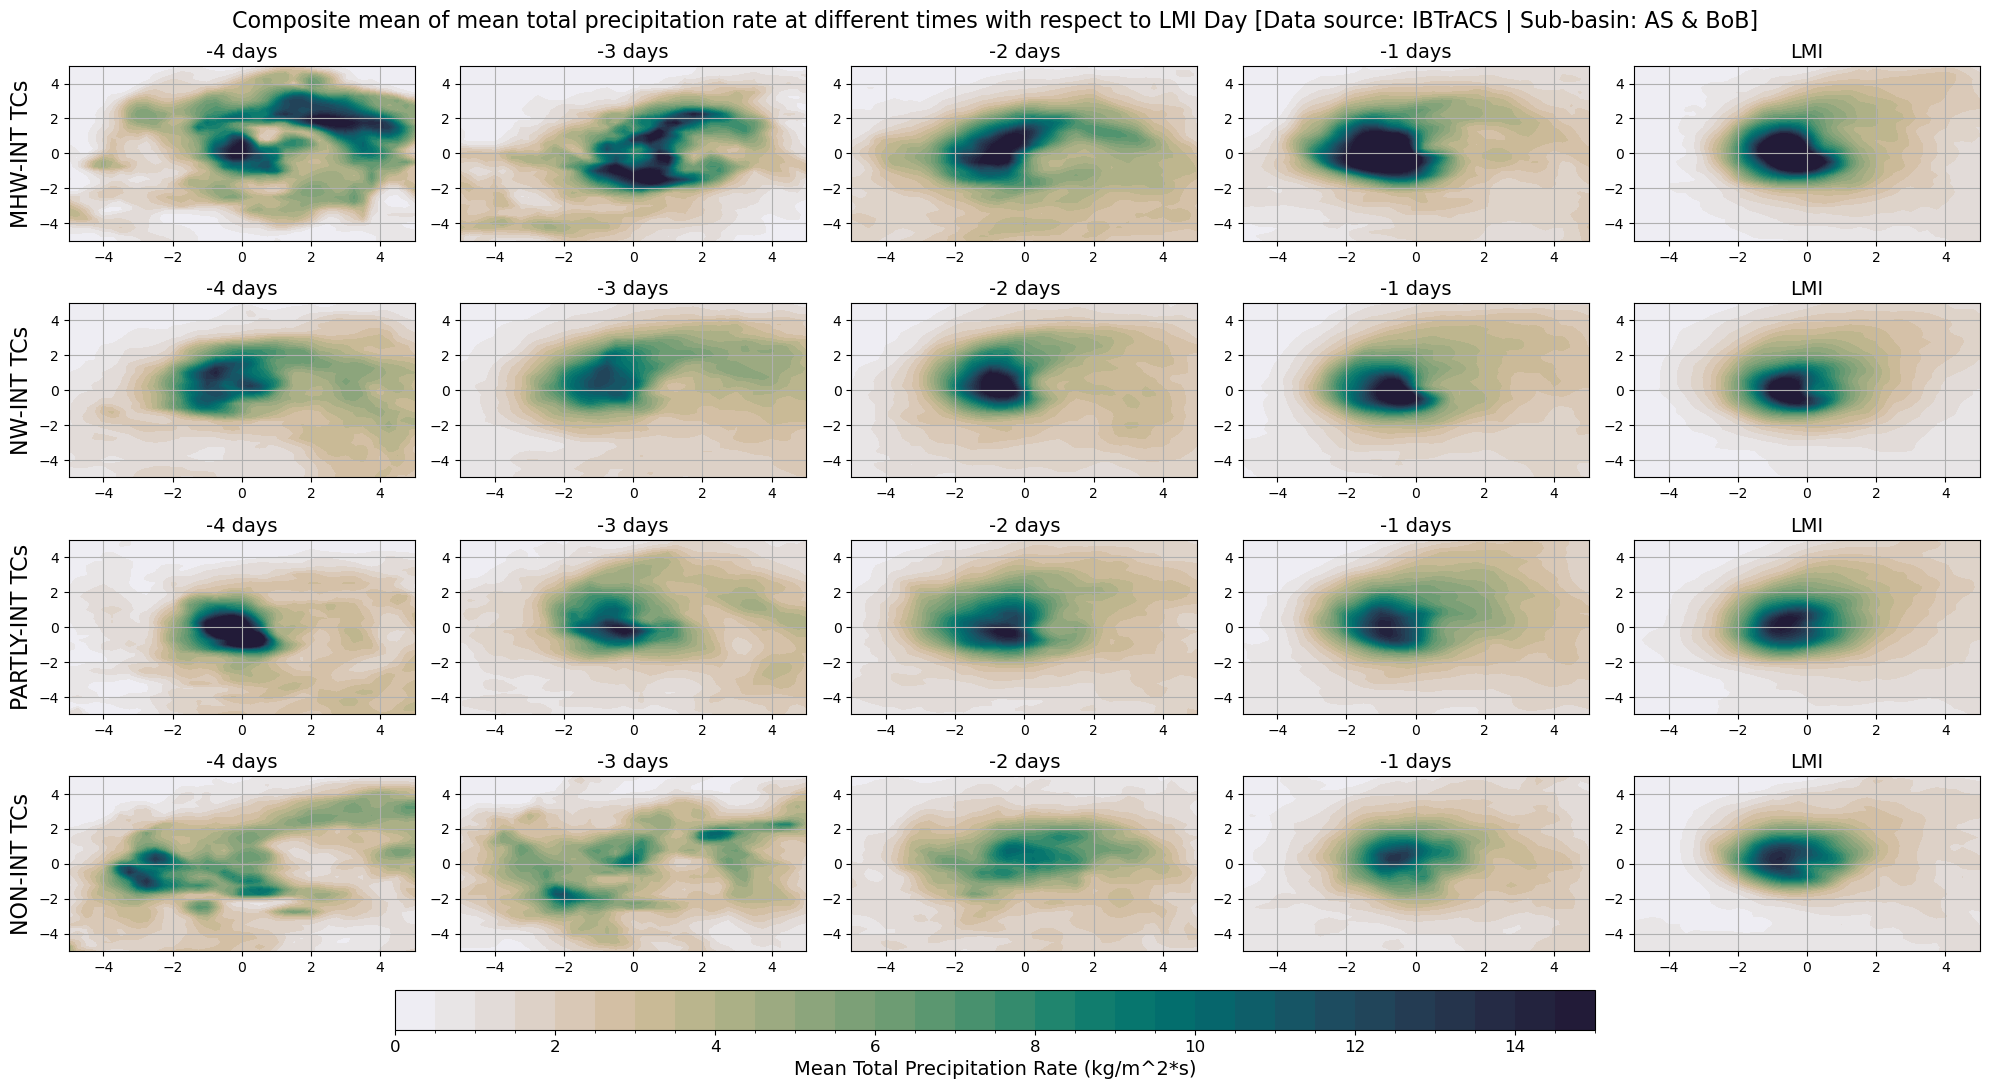

In [31]:
# Plotting composite mean total precipitation rate in lead up to LMI day.
fig, axes = plt.subplots(4,5, figsize = (20,10)) 
if BASIN != 'BOTH':
    fig.suptitle('Composite mean of mean total precipitation rate at different times with respect to LMI Day [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, BASIN), fontsize = 16)
else:
    fig.suptitle('Composite mean of mean total precipitation rate at different times with respect to LMI Day [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, 'AS & BoB'), fontsize = 16)
axes = axes.flatten()

classes = ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']
for idx in range(20):
    c = classes[idx//5]
    era5_ds_tcs_averaged = era5_ds_tcs[c].groupby(era5_ds_tcs[c].TimeRelativeToLMI.astype('int')).mean()
    # Converting 3-hourly precipitation flux data (kg.m^-2.s^-1) to mm/hour units, by multiplying it with number of seconds in 3-hours.
    cbar_map = (era5_ds_tcs_averaged['mtpr']*3*3600).sel(TimeRelativeToLMI = -4+idx%5).plot.contourf(ax = axes[idx], 
                                                                                        levels = np.arange(0,15.5, 0.5), 
                                                                                        cmap = cmo.cm.rain, add_colorbar = False)
    axes[idx].set_xlabel('')

    # Labelling TC class at the start of the row.
    if idx%5 == 0.:
        axes[idx].set_ylabel(c.split('INT')[0]+'INT'+' TCs', fontsize = 16)
    else:
        axes[idx].set_ylabel('')

    # Labelling 'TimeRelativeToLMI' for each column.
    if (-4+idx%5) != 0:
        axes[idx].set_title(str(-4+idx%5) + ' days', fontsize = 14)
    else:
        axes[idx].set_title('LMI', fontsize = 14)
    axes[idx].grid(True)

# Adding common colorbar
cbar_ax = fig.add_axes([0.2, -0.04, 0.6, 0.04])
cbar=fig.colorbar(cbar_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label= "Mean Total Precipitation Rate (kg/m^2*s)", size = 14)
cbar.ax.tick_params(labelsize=12)
fig.tight_layout()
figures += [fig]

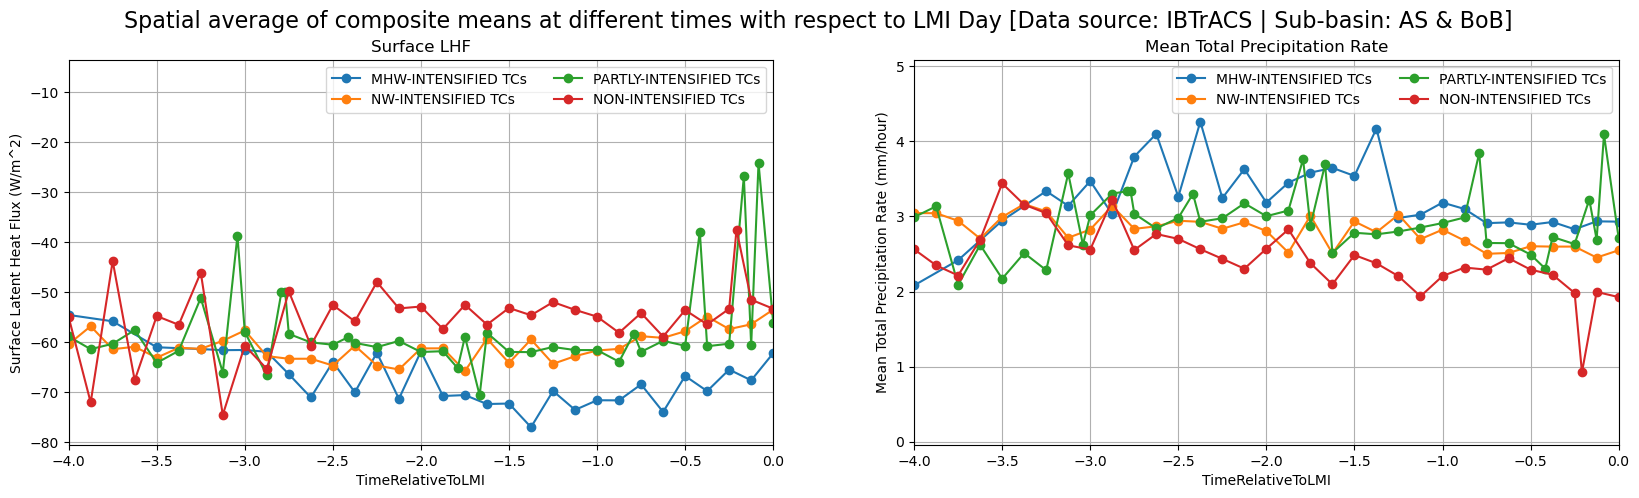

In [32]:
# Plotting spatial average of composite mean for each TC class as a line graph in the lead-up to reaching LMI.
fig, ax = plt.subplots(1,2, figsize = (20,5))
ax = ax.flatten()
if BASIN != 'BOTH':
    fig.suptitle('Spatial average of composite means at different times with respect to LMI Day [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, BASIN), fontsize = 16)
else:
    fig.suptitle('Spatial average of composite means at different times with respect to LMI Day [Data source: {} | Sub-basin: {}]'.format(TRACK_DATA, 'AS & BoB'), fontsize = 16)

# Surface Latent Heat Flux
(era5_ds_tcs['MHW-INTENSIFIED'].groupby(era5_ds_tcs['MHW-INTENSIFIED'].TimeRelativeToLMI).mean()['slhf'].mean(dim = ['latitude', 'longitude'])/(3*3600)).plot(marker = 'o', ax = ax[0], label = 'MHW-INTENSIFIED TCs')
(era5_ds_tcs['NW-INTENSIFIED'].groupby(era5_ds_tcs['NW-INTENSIFIED'].TimeRelativeToLMI).mean()['slhf'].mean(dim = ['latitude', 'longitude'])/(3*3600)).plot(marker = 'o', ax = ax[0], label = 'NW-INTENSIFIED TCs')
(era5_ds_tcs['PARTLY-INTENSIFIED'].groupby(era5_ds_tcs['PARTLY-INTENSIFIED'].TimeRelativeToLMI).mean()['slhf'].mean(dim = ['latitude', 'longitude'])/(3*3600)).plot(marker = 'o', ax = ax[0], label = 'PARTLY-INTENSIFIED TCs')
(era5_ds_tcs['NON-INTENSIFIED'].groupby(era5_ds_tcs['NON-INTENSIFIED'].TimeRelativeToLMI).mean()['slhf'].mean(dim = ['latitude', 'longitude'])/(3*3600)).plot(marker = 'o', ax = ax[0], label = 'NON-INTENSIFIED TCs')
ax[0].set_title('Surface LHF')
ax[0].legend(ncols = 2)
ax[0].set_ylabel('Surface Latent Heat Flux (W/m^2)')
ax[0].set_xlim([-4,0])
ax[0].grid(True)

# Mean Total Precipitation Rate
(era5_ds_tcs['MHW-INTENSIFIED'].groupby(era5_ds_tcs['MHW-INTENSIFIED'].TimeRelativeToLMI).mean()['mtpr'].mean(dim = ['latitude', 'longitude'])*(3*3600)).plot(marker = 'o',ax = ax[1], label = 'MHW-INTENSIFIED TCs')
(era5_ds_tcs['NW-INTENSIFIED'].groupby(era5_ds_tcs['NW-INTENSIFIED'].TimeRelativeToLMI).mean()['mtpr'].mean(dim = ['latitude', 'longitude'])*(3*3600)).plot(marker = 'o', ax = ax[1], label = 'NW-INTENSIFIED TCs')
(era5_ds_tcs['PARTLY-INTENSIFIED'].groupby(era5_ds_tcs['PARTLY-INTENSIFIED'].TimeRelativeToLMI).mean()['mtpr'].mean(dim = ['latitude', 'longitude'])*(3*3600)).plot(marker = 'o', ax = ax[1], label = 'PARTLY-INTENSIFIED TCs')
(era5_ds_tcs['NON-INTENSIFIED'].groupby(era5_ds_tcs['NON-INTENSIFIED'].TimeRelativeToLMI).mean()['mtpr'].mean(dim = ['latitude', 'longitude'])*(3*3600)).plot(marker = 'o', ax = ax[1], label = 'NON-INTENSIFIED TCs')
ax[1].set_title('Mean Total Precipitation Rate')
ax[1].legend(ncols = 2)
ax[1].set_ylabel("Mean Total Precipitation Rate (mm/hour)")
ax[1].set_xlim([-4,0])
ax[1].grid(True)
figures += [fig]

In [33]:
# Saving all the figures into a PDF file
pdf = matplotlib.backends.backend_pdf.PdfPages('./output/{}_{}_pt{:03d}_d{:02d}.pdf'.format(TRACK_DATA, BASIN, int(100*proximity_thres_to_awr), d))
for fig in figures: 
    pdf.savefig(fig)
pdf.close()

---

## EXPERIMENTING STUFF

In [ ]:
import glob

In [ ]:
xr.open_dataset('../SST_anom_AS_full_base_period.nc').rename({'sst':'ssta'})['ssta'], xr.open_dataset('../SST_anom_BoB_full_base_period.nc').rename({'sst':'ssta'})['ssta']

In [ ]:
ssta = {}
ssta['AS'] = xr.open_dataset('../SST_anom_AS_full_base_period.nc').rename({'sst':'ssta'})['ssta'].drop_vars(['dayofyear', 'zlev'])
ssta['BOB'] = xr.open_dataset('../SST_anom_BoB_full_base_period.nc').rename({'sst':'ssta'})['ssta'].drop_vars(['dayofyear', 'zlev'])

In [ ]:
#### FUNCTION TO PAD DATASET ####

def dataset_padder(data):
    target_shape = (41, 41)  # A 10˚ x 10˚ subset of ERA5 data (0.25˚ horizontal resolution, regular lat/lon grid) is of shape (41, 41)
    
    # Calculate padding amounts for each dimension
    pad_x_after = (target_shape[0] - data['lon'].shape[0]) // 2  # Padding to add after for x-dimension
    pad_x_before = (target_shape[0] - data['lon'].shape[0]) - pad_x_after  # Padding to add before for x-dimension
    
    pad_y_after = (target_shape[1] - data['lat'].shape[0]) // 2   # Padding to add after for y-dimension
    pad_y_before = (target_shape[1] - data['lat'].shape[0]) - pad_y_after  # Padding to add before for y-dimension

    # Padding along longitude
    data = data.pad(lon = (pad_x_before,pad_x_after), constant_value = np.nan)
    # Padding along latitude
    data = data.pad(lat = (pad_y_before,pad_y_after), constant_value = np.nan)
    
    return data

In [ ]:
# Dictionary to save data subsetted for select timestamps/location 
# where BT of a particular class of TC passes over. This dataset will
# later be used to calculate composite means and its spatial average.
era5_ds_tcs = {}  

# Looping over each category of TC, as classified above.
for c in ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']:
    era5_ds_tcs[c] = [] # List to store dataset for each timestep.
    tcs_df_subset = tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == c]
    for row in tqdm(tcs_df_subset.iterrows()):
        
        # Here, 'row' is each data entry for cyclones classified as 'c' earlier.
        # Selecting data at a particular timestep ('row' index value) from the appropriate ERA5 dataset.
        if (float(ssta['AS'].lon.min()) <= row[1]['LON'] <= float(ssta['AS'].lon.max())) & (float(ssta['AS'].lat.min()) <= row[1]['LAT'] <= float(ssta['AS'].lat.max())):
            ds_selected = ssta['AS'].sel(time = row[0], drop = False, method = 'nearest')
        else:
            ds_selected = ssta['BOB'].sel(time = row[0], drop = False, method = 'nearest')

        # Sorting selected dataset based on ascending order of 'latitude' and 'longitude'.   
        ds_selected = ds_selected.sortby('lat')
        ds_selected = ds_selected.sortby('lon')

        # Finding out which lat/lon of the ERA5 grid is nearest to the lat/lon of 'row'.
        latn = ds_selected['lat'].sel(lat = row[1]['LAT'], method = 'nearest').item()
        lonn = ds_selected['lon'].sel(lon = row[1]['LON'], method = 'nearest').item()

        # Subsetting a 10˚ x 10˚ box, with centre as 'latn' and 'lonn' determined from the above step.
        ds_selected = ds_selected.sel(lat = slice(latn-5.15, latn+5.15), lon = slice(lonn-5.05, lonn+5.05))
        # As some BT locations (i.e., 'latn/lonn') fall close to the boundary points of 'ds_selected',
        # it may not be possible to crop exactly 10˚ x 10˚ box i.e., (41,41) shaped box.
        # Hence, to deal with this issue I've made this dataset_padder() function, which pads both ends
        # of the box (both in vertical and horizontal directions) with NaN values to preserve shape.
        # This is particularly needed when merging cropped datasets for each timestep into a single
        # dataset at the end of each iteration (below).
        ds_selected = dataset_padder(ds_selected)
        # Revaluing 'latitude' and 'longitude' to be ranging from -5˚ to 5˚ with (0˚,0˚) as the centre
        # over which the BT passes, at each timestep.
        ds_selected['lat'] = np.arange(-5,5.1, 0.25)
        ds_selected['lon'] = np.arange(-5,5.1, 0.25)
        # Drop unneccesary variables that have been pre-identified, if they exist in ds_selected.
        ds_selected = ds_selected.drop_vars('time')
        if 'number' in list(ds_selected.coords):
            ds_selected = ds_selected.drop_vars('number')
        elif 'expver' in list(ds_selected.coords):
            ds_selected = ds_selected.drop_vars('expver')
        # As we've selected a single timestep, we lose that dimension from the dataset. Here I'm simply 
        # adding it back. This will be useful for merging the datasets immediately after this loop.
        ds_selected = ds_selected.expand_dims({'time':[row[0]]})

        # Adding the dataset for 'row' timestep to the list.
        era5_ds_tcs[c] += [ds_selected]
        
    # Merging the datasets based across the 'valid_time' axis.
    era5_ds_tcs[c] = xr.merge(era5_ds_tcs[c])

    # Assigning 'TimeRelativeToLMI' as a coordinate with 'time' as the dimension.
    # This will be used to group-by and take a mean, hence creating a composite for each 'TimeRelativeToLMI'.
    era5_ds_tcs[c]['TimeRelativeToLMI'] = list(tcs_df_subset['TimeRelativeToLMI'])
    era5_ds_tcs[c] = era5_ds_tcs[c].assign_coords(TimeRelativeToLMI = ('time', list(tcs_df_subset['TimeRelativeToLMI'])))

In [ ]:
tcs_lmi_centred_selected['MEAN_SSTA_10deg'] = np.nan

In [ ]:
for row in tqdm(tcs_lmi_centred_selected.iterrows()):    
    # Here, 'row' is each data entry for cyclones classified as 'c' earlier.
    # Selecting data at a particular timestep ('row' index value) from the appropriate ERA5 dataset.
    if (float(ssta['AS'].lon.min()) <= row[1]['LON'] <= float(ssta['AS'].lon.max())) & (float(ssta['AS'].lat.min()) <= row[1]['LAT'] <= float(ssta['AS'].lat.max())):
        ds_selected = ssta['AS'].sel(time = row[0], drop = False, method = 'nearest')
    else:
        ds_selected = ssta['BOB'].sel(time = row[0], drop = False, method = 'nearest')

    # Sorting selected dataset based on ascending order of 'latitude' and 'longitude'.   
    ds_selected = ds_selected.sortby('lat')
    ds_selected = ds_selected.sortby('lon')

    # Finding out which lat/lon of the ERA5 grid is nearest to the lat/lon of 'row'.
    latn = ds_selected['lat'].sel(lat = row[1]['LAT'], method = 'nearest').item()
    lonn = ds_selected['lon'].sel(lon = row[1]['LON'], method = 'nearest').item()

    # Subsetting a 10˚ x 10˚ box, with centre as 'latn' and 'lonn' determined from the above step.
    ds_selected = ds_selected.sel(lat = slice(latn-5.15, latn+5.15), lon = slice(lonn-5.05, lonn+5.05))
    # As some BT locations (i.e., 'latn/lonn') fall close to the boundary points of 'ds_selected',
    # it may not be possible to crop exactly 10˚ x 10˚ box i.e., (41,41) shaped box.
    # Hence, to deal with this issue I've made this dataset_padder() function, which pads both ends
    # of the box (both in vertical and horizontal directions) with NaN values to preserve shape.
    # This is particularly needed when merging cropped datasets for each timestep into a single
    # dataset at the end of each iteration (below).
    ds_selected = dataset_padder(ds_selected)
    # Revaluing 'latitude' and 'longitude' to be ranging from -5˚ to 5˚ with (0˚,0˚) as the centre
    # over which the BT passes, at each timestep.
    ds_selected['lat'] = np.arange(-5,5.1, 0.25)
    ds_selected['lon'] = np.arange(-5,5.1, 0.25)
    # Drop unneccesary variables that have been pre-identified, if they exist in ds_selected.
    ds_selected = ds_selected.drop_vars('time')
    tcs_lmi_centred_selected.at[row[0],'MEAN_SSTA_10deg'] = float(ds_selected.mean(dim = ['lat', 'lon']))

In [ ]:
for c in ['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED']:
    plt.scatter(.values, .values)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have arrays `sst_anomalies`, `msws`, and `classes`
sns.scatterplot(x=tcs_lmi_centred_selected['MEAN_SSTA_10deg'], y=tcs_lmi_centred_selected['TimeRelativeToLMI'], hue=tcs_lmi_centred_selected['TC_AWRINT_CLASS'], palette="Set1", alpha = 0.2)
plt.xlabel('SST Anomaly (°C)')
plt.ylabel('Maximum Sustained Wind Speed (MSWS)')
plt.title('MSWS vs SSTA for Different Classes')
plt.show()


In [ ]:
era5_ds_tcs['MHW-INTENSIFIED'].mean(dim = ['lon', 'lat'])['ssta']

In [ ]:
fig, ax = plt.subplots(1,1)
colors = ['tab:red', 'tab:orange', 'tab:brown', 'tab:blue']
for tc_class, c in zip(['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED'], colors):
    ax.scatter(era5_ds_tcs[tc_class].mean(dim = ['lon', 'lat'])['ssta'].values, tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_class]['MSWS'].values, color = c, alpha = 0.2)

In [ ]:
era5_ds_tcs[tc_class].mean(dim = ['lon', 'lat'])['ssta'].values.shape, tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_class]['MSWS'].values.shape

In [ ]:
fig, ax = plt.subplots(1,1)
colors = ['tab:red', 'tab:orange', 'tab:brown', 'tab:blue']
for tc_class, c in zip(['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'PARTLY-INTENSIFIED', 'NON-INTENSIFIED'], colors):
    ax.scatter(era5_ds_tcs[tc_class].mean(dim = ['lon', 'lat'])['ssta'].values, tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_class]['CAT'].values, color = c, alpha = 0.2)

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes= axes.flatten()
colors = ['tab:red', 'tab:orange', 'tab:blue']
ax = axes[0]
for tc_class, c in zip(['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'NON-INTENSIFIED'], colors):
    ax.scatter(era5_ds_tcs[tc_class].mean(dim = ['lon', 'lat'])['ssta'].values, tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_class]['TimeRelativeToLMI'].values, color = c, alpha = 0.5)
    ax.set_xlabel('SST Anomaly')
    ax.set_ylabel('Time relative to LMI')
    ax.set_title('TimeRelativeToLMI x SSTA')
ax = axes[1]
for tc_class, c in zip(['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'NON-INTENSIFIED'], colors):
    c = ax.scatter(era5_ds_tcs[tc_class].mean(dim = ['lon', 'lat'])['ssta'].values, tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_class]['MSWS'].values, color = c, alpha = 0.5, label = tc_class)
    ax.set_xlabel('SST Anomaly')
    ax.set_ylabel('MSWS (knots)')
    ax.set_title('MSWS x SSTA')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.8, -0.025), ncols = 3)
fig.tight_layout()

In [ ]:
sst_anomalies = 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have arrays `sst_anomalies`, `msws`, and `classes`
sns.scatterplot(x=sst_anomalies, y=msws, hue=classes, palette="Set1")
plt.xlabel('SST Anomaly (°C)')
plt.ylabel('Maximum Sustained Wind Speed (MSWS)')
plt.title('MSWS vs SSTA for Different Classes')
plt.show()


In [ ]:
tc_class

In [ ]:
era5_ds_tcs[tc_class].mean(dim = ['lon', 'lat'])['ssta'].values.shape

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (30,10))
axes= axes.flatten()
colors = ['Reds', 'Oranges', 'copper', 'Blues']
ax = axes[0]
for tc_class, c in zip(['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'NON-INTENSIFIED'], colors):
    sns.kdeplot(x = era5_ds_tcs[tc_type].mean(dim = ['lon', 'lat'])['ssta'].values, y = tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_type]['MSWS'].values, cmap=c, shade=True, alpha = 0.5)
    ax.set_xlabel('SST Anomaly')
    ax.set_ylabel('Time relative to LMI')
    ax.set_title('TimeRelativeToLMI x SSTA')
ax = axes[1]
for tc_class, c in zip(['MHW-INTENSIFIED', 'NW-INTENSIFIED', 'NON-INTENSIFIED'], colors):
    sns.kdeplot(x = era5_ds_tcs[tc_type].mean(dim = ['lon', 'lat'])['ssta'].values, y = tcs_lmi_centred_selected[tcs_lmi_centred_selected['TC_AWRINT_CLASS'] == tc_type]['MSWS'].values, cmap=c, shade=True, alpha = 0.5)
    ax.set_xlabel('SST Anomaly')
    ax.set_ylabel('MSWS (knots)')
    ax.set_title('MSWS x SSTA')
    ax.legend(ncols = 2)
fig.tight_layout()

In [ ]:
import seaborn as sns

for tc

plt.xlabel('SST Anomaly (°C)')
plt.ylabel('Maximum Sustained Wind Speed (MSWS)')
plt.title('KDE Plot: SST Anomaly vs MSWS')
plt.show()